# **Traffic Sign Recognition System** - An application testing for ZCU102

## Introduzione

Nel contesto dell'esplorazione delle potenziali applicazioni della board ZCU102, si è scelto di sviluppare e sperimentare un modello AI per la recognition dei segnali stradali. Questa applicazione ha un ruolo significativo nel contesto della guida autonoma e dei veicoli intelligenti. Il modello sarà in grado di analizzare immagini dei simboli stradali e di restituire le etichette corrispondenti a ciascun segnale riconosciuto. Per raggiungere questo obiettivo, si utilizzerà un modello di rete neurale convoluzionale. L'intero processo di progettazione e addestramento del modello sarà gestito attraverso l'uso delle API di PyTorch. 

E' stato impiegato per condurre una sperimentazione sulla differenza di prestazioni tra la GPU di Kaggle e la Digital Processing Unit (DPU) presente sulla scheda ZCU102. La DPU, implementata sull'FPGA della ZCU102, offre prestazioni ottimizzate per l'esecuzione di reti neurali. Utilizzando PyTorch, è stato possibile sviluppare e addestrare un modello di rete neurale utilizzando l'API fornita dalla libreria Vitis AI, successivamente sfruttando l'accelerazione offerta dalla DPU per eseguire l'inferenza del modello sulla ZCU102.

#### Installazione delle librerie e delle API necessarie.


In [1]:
# Libreria per mostrare il summary del modello 
!pip install torchsummary

In [2]:
# Librerie di sistema e computer vision
import gc, os, cv2, PIL
import time

# Librerie di Pytorch
import torch
import torchvision as tv
import torch.nn as nn
import torchsummary as ts

# Librerie utili per le valutazioni
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Librerie utili per l'oversampling
from imblearn.over_sampling import RandomOverSampler


##### Controllo della versione di Pytorch
Utile per garantire la compatibilità richiesta dalla board (PyTorch 1.9)

In [3]:
# Controllo della versione di PyTorch 
print(torch.__version__)

1.9.1


### Raccolta dati
Il dataset utilizzato per questo progetto è il Traffic Signs Classification, un ampio database di segnali stradali suddivisi in 43 classi, di cui le immagini sono state opportunamente ritagliate. Questo dataset è stato acquisito dal German Traffic Sign Recognition Benchmark e presenta le seguenti caratteristiche: 

- Oltre 40 classi di segnali stradali
- Più di 50.000 immagini in totale
- Un database ampio e realistico

Il dataset è stato scelto per la sua ampiezza e per la sua somiglianza alla realtà, offrendo una rappresentazione significativa dei diversi segnali stradali che si possono incontrare nel contesto reale. Questo permette al modello di essere addestrato su un ampio spettro di situazioni e di acquisire una comprensione accurata dei segnali stradali, migliorando così la sua capacità di riconoscimento e classificazione. 


#### Leggere il file labels.csv che contiene i metadati sulle etichette dei segnali stradali. 
Si elencano le classi per la recognition delle indicazioni stradali.

In [4]:
labels_df = pd.read_csv('../input/traffic-signs-classification/labels.csv')
labels_df

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


#### Importare il set di immagini con le etichette necessarie per addestrare e testare il modello.

In [5]:
%%time 
# %%time usato per il calcolo del tempo di esecuzione della singola cella

x = [] # x vettore per memorizzare le immagini
y = [] # y vettore per memorizzare i rispettivi labels

# raccolta delle immagini dalla cartella myData
data_dir = '../input/traffic-signs-classification/myData'

# Caricamento immagini cartelle segnali stradali, conversione tensori, liste input/target addestramento.
for folder in range(43):
    folder_path = os.path.join(data_dir,str(folder)) # os.path.join just join both string 
    for i,img in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path,img)
        # PIL carica l'immagine come oggetto PIL e con ToTensor converte come Tensore
        img_tensor = tv.transforms.ToTensor()(PIL.Image.open(img_path))
        x.append(img_tensor.tolist())
        y.append(folder)
    print('folder of label',folder,'images loaded. Number of samples :',i+1)
    
x = np.array(x)
y = np.array(y)

folder of label 0 images loaded. Number of samples : 451
folder of label 1 images loaded. Number of samples : 4920
folder of label 2 images loaded. Number of samples : 2610
folder of label 3 images loaded. Number of samples : 2670
folder of label 4 images loaded. Number of samples : 3750
folder of label 5 images loaded. Number of samples : 3510
folder of label 6 images loaded. Number of samples : 780
folder of label 7 images loaded. Number of samples : 2730
folder of label 8 images loaded. Number of samples : 2670
folder of label 9 images loaded. Number of samples : 2790
folder of label 10 images loaded. Number of samples : 3810
folder of label 11 images loaded. Number of samples : 2490
folder of label 12 images loaded. Number of samples : 3990
folder of label 13 images loaded. Number of samples : 4080
folder of label 14 images loaded. Number of samples : 1470
folder of label 15 images loaded. Number of samples : 1170
folder of label 16 images loaded. Number of samples : 780
folder of 

#### Split del dataset in training e testing set


In [6]:
# calcola il numero di immagini per il testing set
total_items = len(x)
test_items = 10000

# calcola la proporzione di testing set
test_size = test_items / total_items

# splitting stratificato del dataset con dimensione dello split test di 10000 immagini
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=test_size,stratify=y)
del x,y
gc.collect() # delete x, y e libera la memoria
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape # shape dei dati splittati

((63139, 3, 32, 32), (10000, 3, 32, 32), (63139,), (10000,))

#### Gestione dei dati sbilanciati

##### Check - dataset bilanciato 


In [7]:
# np.unique restituisce tutte le etichette come un array 
# numero di campioni disponibili rispetto a quell'etichetta come un altro array. 
np.unique(ytrain,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([ 389, 4247, 2253, 2305, 3237, 3030,  673, 2357, 2305, 2409, 3289,
        2150, 3444, 3522, 1269, 1010,  673, 1813, 1968,  337,  570,  518,
         622,  829,  440, 2460,  984,  388,  881,  440,  725, 1269,  389,
        1112,  673, 1968,  622,  337, 3393,  492,  570,  388,  389]))

Quindi, in base ai risultati di cui sopra (secondo array), il set di dati è molto sbilanciato e deve essere bilanciato.

##### Applicare il sovracampionamento per bilanciare il set di dati

In [8]:
# appiattisce xtrain poiché RandomOverSampler accetta solo matrici bidimensionali.
xtrain = xtrain.reshape(xtrain.shape[0],3*32*32) 

# il metodo RandomOverSampler duplica i campioni nella classe di minoranza per bilanciare il set di dati.
xtrain,ytrain = RandomOverSampler().fit_resample(xtrain,ytrain)

xtrain = xtrain.reshape(xtrain.shape[0],3,32,32) # reshape
xtrain.shape, ytrain.shape

((182621, 3, 32, 32), (182621,))

##### Si verifica di nuovo se il set di dati è bilanciato o meno


In [9]:
np.unique(ytrain,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247,
        4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247,
        4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247,
        4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247, 4247]))

Ora il set di dati è bilanciato.


#### Mostra 100 immagini di campioni di allenamento come una griglia usando matplotlib

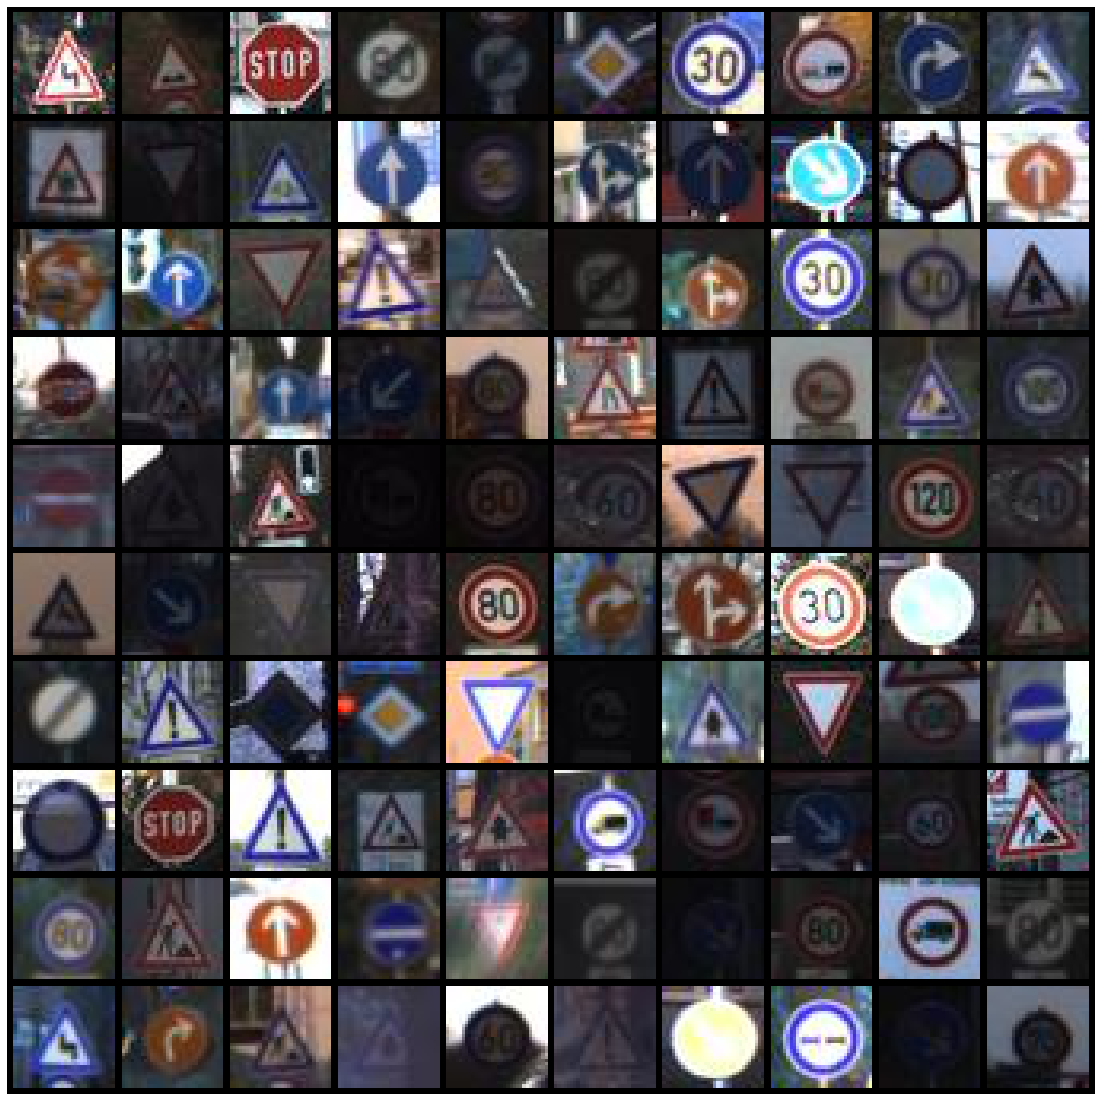



Labels delle precedenti immagini:



array([21, 22, 14,  6, 42, 12,  1,  9, 33, 31, 30, 13, 29, 35,  5, 36, 35,
       38, 15, 35, 34, 35, 13, 18, 29,  6, 36,  1,  1, 11, 14, 25, 35, 39,
        5, 24, 18, 10, 25,  7, 17, 11, 25, 10,  5,  3, 13, 13,  8,  3, 31,
       38, 13, 25,  5, 33, 36,  1, 38, 26, 32, 18, 12, 12, 13, 10, 11, 13,
        7, 17, 15, 14, 18, 25, 11, 16, 10, 38,  3, 25,  5, 25, 35, 17, 13,
        6, 38,  5, 16,  6, 21, 33, 25, 11,  3, 18, 38,  9, 38,  4])

In [10]:
plt.figure(figsize=(20,20)) 
plt.imshow(tv.utils.make_grid(torch.tensor(xtrain[:100]),nrow=10).permute(1,2,0))
plt.axis('off') # Per rimuovere xticks e yticks
plt.show()

print('\n\nLabels delle precedenti immagini:\n')
ytrain[:100]

#### Convertire i dati del treno e del test da un array numpy a un tensore per ulteriori calcoli.

In [11]:
xtrain = torch.from_numpy(xtrain) 
ytrain = torch.from_numpy(ytrain)
xtest = torch.from_numpy(xtest)
ytest = torch.from_numpy(ytest)

### Inizializzazione del modello di rete neurale - LeNet
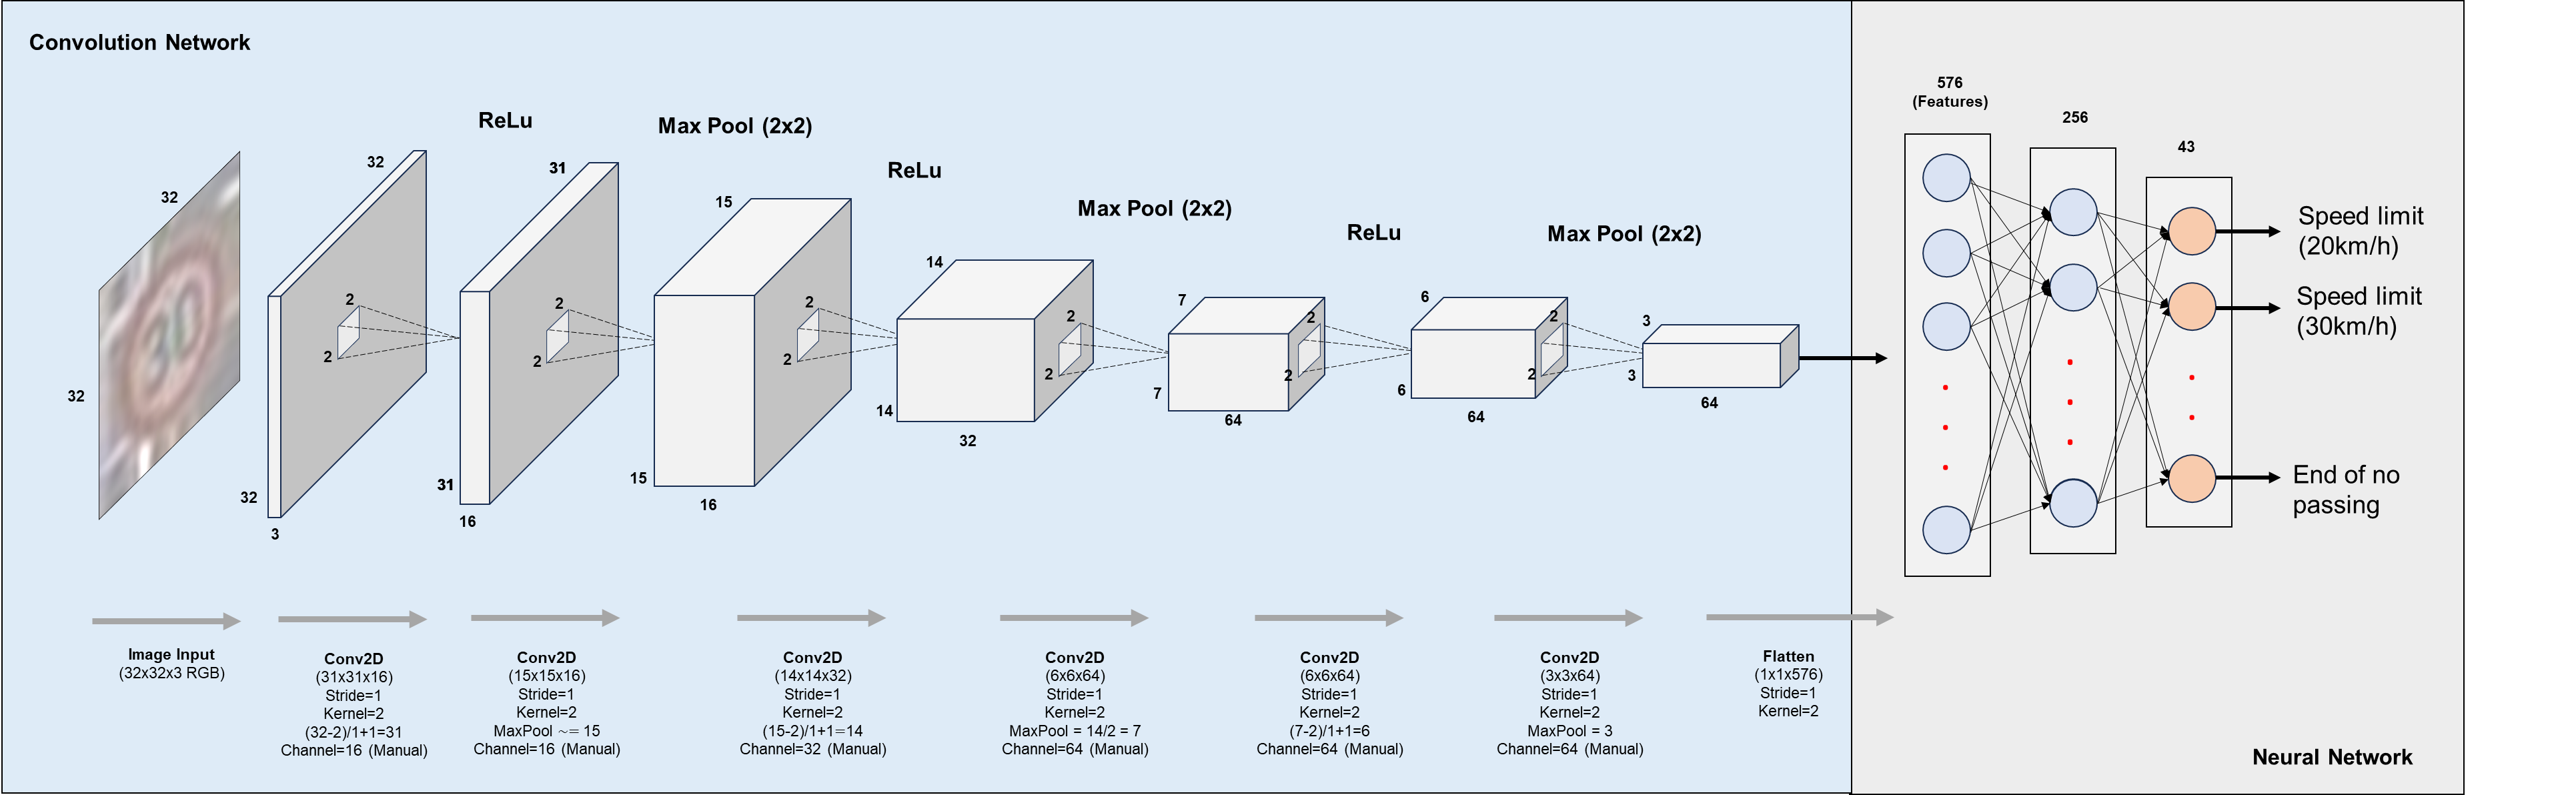

In [12]:
def get_same_padding(kernel_size):
    if isinstance(kernel_size, tuple):
        padding = tuple((k - 1) // 2 for k in kernel_size)
    else:
        padding = (kernel_size - 1) // 2
    return padding

model = nn.Sequential(
    # 1st convolutional network Layers
    nn.Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=get_same_padding((2, 2))),  # Convolution
    nn.BatchNorm2d(16),  # Normalization
    nn.ReLU(inplace=True),  # Activation
    nn.MaxPool2d(kernel_size=(2, 2)),  # Pooling

    # 2nd convolutional network Layers
    nn.Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=get_same_padding((2, 2))),  # Convolution
    nn.BatchNorm2d(32),  # Normalization
    nn.ReLU(inplace=True),  # Activation
    nn.MaxPool2d(kernel_size=(2, 2)),  # Pooling

    # 3rd convolutional network Layers
    nn.Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=get_same_padding((2, 2))),  # Convolution
    nn.BatchNorm2d(64),  # Normalization
    nn.ReLU(inplace=True),  # Activation
    nn.MaxPool2d(kernel_size=(2, 2)),  # Pooling

    # Flatten Data
    nn.Flatten(),  # Flatten

    # feed forward Layers
    nn.Linear(576, 256),  # Linear
    nn.ReLU(inplace=True),  # Activation
    
    nn.Linear(256, 43)   # Linear
)

# invia modello verso la cuda
model = model.to(torch.device('cuda'),non_blocking=True)

# generazione del summary del modello
ts.summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]             208
       BatchNorm2d-2           [-1, 16, 31, 31]              32
              ReLU-3           [-1, 16, 31, 31]               0
         MaxPool2d-4           [-1, 16, 15, 15]               0
            Conv2d-5           [-1, 32, 14, 14]           2,080
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 6, 6]           8,256
      BatchNorm2d-10             [-1, 64, 6, 6]             128
             ReLU-11             [-1, 64, 6, 6]               0
        MaxPool2d-12             [-1, 64, 3, 3]               0
          Flatten-13                  [-1, 576]               0
           Linear-14                  [

#### Definire la funzione Evaluate per la valutazione della perdita e dell'accuratezza del modello e la funzione Train Model per l'addestramento del modello.

In [13]:
def evaluate(model, data, target):
    # invio di dati e target alla memoria cuda
    data = data.to(torch.device('cuda'),non_blocking=True)
    target = target.to(torch.device('cuda'),non_blocking=True)
    length = len(target)
    yhat = model(data) # predizione 
    
    # calcolo della predizione da yhat
    ypred = yhat.argmax(axis=1) 
    
    # calcolo della loss
    loss = float(nn.functional.cross_entropy(yhat, target)) 
    
    # calcolo dell'accuracy
    acc = float((ypred == target).sum() / length) 
    
    # la print loss e accuracy
    print('Loss :',round(loss,4),'- Accuracy :',round(acc,4)) 
    
    # pulizia delle variabili usate e della memoria cache della CUDA
    del data,target,yhat,ypred 
    torch.cuda.empty_cache()

#### Valutiamo il modello sul testing set prima dell'addestramento


In [14]:
print('\nInitial Loss and Accuracy on Test Dataset :')
evaluate(model,xtest.float(),ytest)


Initial Loss and Accuracy on Test Dataset :
Loss : 3.7729 - Accuracy : 0.0386


#### Definire la funzione Train Model per addestrare il modello.

In [15]:
def train_model(model=model,
                optimizer=torch.optim.Adam,
                epochs=5,
                batch_size=100,
                steps_per_epochs=100,
                l2_reg=0,
                max_lr=0.01,
                grad_clip=0.5):
    
    hist = [[],[],[],[]] # hist memorizzerà le perdite dei dati di addestramento e di test e l'accuratezza di ogni epoca
    
    # Preparazione del dataset di training per il Data Loader
    train_ds = [(x,y) for x,y in zip(xtrain,ytrain)] 
    
    # Data Loader usato per il train model
    training_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size)  
    
    # Data Loader per epoch e evaluation sul train data
    train_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size * steps_per_epochs) 
    
    del train_ds 
    gc.collect() # Delete le used variable e free up memory
    
    # Initialized the Optimizer to update weights and bias of model parameters
    optimizer = optimizer(model.parameters(),weight_decay=l2_reg)
    
    # Initialized the Schedular to update learning rate as per one cycle poicy  
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs, steps_per_epoch=int(steps_per_epochs * 1.01))
        
    # Training Started
    for i in range(epochs):
                 
        print('\nEpoch' , i+1 , ': [',end="")
        
        # Carica i batch del training data loader
        # Load Batches of training data loader
        for j,(xb,yb) in enumerate(training_dl):
            
            # ogni training batch spostato nella cuda memory per velocizzare il processing
            xb = xb.to(torch.device('cuda'),non_blocking=True)
            yb = yb.to(torch.device('cuda'),non_blocking=True)
            
            # calcolo della Loss e gradienti
            yhat = model(xb.float())
            loss = nn.functional.cross_entropy(yhat, yb)
            loss.backward()
            
            # clip degli outlier like gradients
            nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            
            # aggiornamento dei weights and bias
            optimizer.step()
            optimizer.zero_grad()
            
            # aggiornamento della Learning Rate
            sched.step()
            
            del xb,yb,yhat
            torch.cuda.empty_cache()
            # delete the used data and free up space
            
            # print del training epochs progress
            if j % int(steps_per_epochs / 20) == 0:
                print('.',end='')
                
            # break the loop quando arriva al numero fissato 
            if steps_per_epochs == j :
                break
                             
           
        # Epochs end evaluation 
        
        device = torch.device('cuda') # initialized cuda to device
        
        # caricamento del training data batches from train data loader
        for xtrainb,ytrainb in train_dl:
            break
        
        # move train data to cuda
        xtrain_cuda = xtrainb.to(device,non_blocking=True)
        ytrain_cuda = ytrainb.to(device,non_blocking=True)
        
        # delete used variables and free up space
        del xtrainb, ytrainb
        gc.collect()
        
        # calcolo del train loss e accuracy
        yhat = model(xtrain_cuda.float())
        ypred = yhat.argmax(axis=1)
        train_loss = float(nn.functional.cross_entropy(yhat, ytrain_cuda))
        train_acc = float((ypred == ytrain_cuda).sum() / len(ytrain_cuda))
        
        # delete used variables and free up space
        del xtrain_cuda, ytrain_cuda, yhat, ypred
        torch.cuda.empty_cache()
        
        
        # move test data to cuda
        xtest_cuda = xtest.to(device,non_blocking=True)
        ytest_cuda = ytest.to(device,non_blocking=True)
        
        # Calculate test loss and accuracy
        yhat = model(xtest_cuda.float())
        ypred = yhat.argmax(axis=1)
        val_loss = float(nn.functional.cross_entropy(yhat, ytest_cuda))
        val_acc = float((ypred == ytest_cuda).sum() / len(ytest_cuda))
        
        del xtest_cuda, ytest_cuda, yhat, ypred
        torch.cuda.empty_cache()
        # delete used variables and free up space
        
        # print the captured train and test loss and accuracy at the end of every epochs
        print('] - Train Loss :',round(train_loss,4),'- Train Accuracy :',round(train_acc,4),
              '- Val Loss :',round(val_loss,4), '- Val Accuracy :',round(val_acc,4))
        
        # store that data into the previously blank initialized hist list 
        hist[0].append(train_loss)
        hist[1].append(val_loss)
        hist[2].append(train_acc)
        hist[3].append(val_acc)
        
    # Initialized all the evaluation history of all epochs to a dict
    history = {'Train Loss':hist[0],'Val Loss':hist[1],'Train Accuracy':hist[2], 'Val Accuracy':hist[3]}
    
    # return the history as pandas dataframe
    return pd.DataFrame(history)

#### Addestramento del modello

In [16]:
%%time
history = train_model(model,optimizer=torch.optim.Adam,epochs=25,steps_per_epochs=100,l2_reg=0,max_lr=0.015,grad_clip=0.5)


Epoch 1 : [.....................] - Train Loss : 1.4484 - Train Accuracy : 0.6069 - Val Loss : 1.5272 - Val Accuracy : 0.5755

Epoch 2 : [.....................] - Train Loss : 0.508 - Train Accuracy : 0.8535 - Val Loss : 0.6046 - Val Accuracy : 0.8195

Epoch 3 : [.....................] - Train Loss : 0.3213 - Train Accuracy : 0.9013 - Val Loss : 0.4212 - Val Accuracy : 0.8694

Epoch 4 : [.....................] - Train Loss : 0.2978 - Train Accuracy : 0.9011 - Val Loss : 0.4182 - Val Accuracy : 0.874

Epoch 5 : [.....................] - Train Loss : 0.229 - Train Accuracy : 0.9305 - Val Loss : 0.3519 - Val Accuracy : 0.8985

Epoch 6 : [.....................] - Train Loss : 0.2219 - Train Accuracy : 0.9339 - Val Loss : 0.3536 - Val Accuracy : 0.9023

Epoch 7 : [.....................] - Train Loss : 0.1747 - Train Accuracy : 0.9421 - Val Loss : 0.3011 - Val Accuracy : 0.9163

Epoch 8 : [.....................] - Train Loss : 0.1077 - Train Accuracy : 0.9658 - Val Loss : 0.2534 - Val Accur

#### Model History

In [17]:
history

,Train Loss,Val Loss,Train Accuracy,Val Accuracy
0,1.448432,1.527244,0.6069,0.5755
1,0.508017,0.604640,0.8535,0.8195
2,0.321318,0.421171,0.9013,0.8694
3,0.297771,0.418166,0.9011,0.8740
4,0.228957,0.351860,0.9305,0.8985
5,0.221926,0.353628,0.9339,0.9023
6,0.174696,0.301067,0.9421,0.9163
7,0.107733,0.253363,0.9658,0.9283
8,0.087251,0.247161,0.9748,0.9344
9,0.093526,0.277190,0.9737,0.9372


#### Visualizzazione della Training History

In [18]:
# plotting
fig = px.line(history.iloc[:,:2],title='Loss Per Epochs',labels={'value':'Loss','index':'Epochs'})
fig.update_layout(title={'font_family':'Arial','font_size':23,'x':0.5}).show()
fig = px.line(history.iloc[:,2:],title='Accuracy Per Epochs',labels={'value':'Accuracy','index':'Epochs'})
fig.update_layout(title={'font_family':'Arial','font_size':23,'x':0.5}).show()

#### Rapporto di classificazione del modello sul testing set

In [22]:
# sposta xtest verso la cuda
xtest = xtest.to(torch.device('cuda'),non_blocking=True)

# generazione delle predizioni
start = time.time() #per la valutazione del throughput
a = torch.cuda.memory_allocated('cuda')
ypred = model(xtest.float()).argmax(axis=1)
b = torch.cuda.memory_allocated('cuda')
end = time.time()
total_time = end - start

total_memory = b - a

# riporta xtest, ypred verso la cpu
xtest = xtest.to(torch.device('cpu'),non_blocking=True)
ypred = ypred.to(torch.device('cpu'),non_blocking=True)

# calcola le matrici di classificazione e stampa il risultato
throughput = len(ytest) / total_time
print(classification_report(ytest,ypred,digits=4))

print('Throughput: {} fps'.format(throughput))
print('Usage memory for inference: %.4f kB '%(total_memory*(10 ** -3)))

              precision    recall  f1-score   support

           0     0.9825    0.9032    0.9412        62
           1     0.9747    0.9747    0.9747       673
           2     0.9438    0.9412    0.9425       357
           3     0.9642    0.9589    0.9615       365
           4     0.9801    0.9610    0.9705       513
           5     0.9665    0.9625    0.9645       480
           6     1.0000    0.9813    0.9906       107
           7     0.9406    0.9759    0.9579       373
           8     0.9643    0.9616    0.9630       365
           9     0.9767    0.9921    0.9844       381
          10     0.9942    0.9942    0.9942       521
          11     0.9849    0.9588    0.9717       340
          12     0.9891    0.9927    0.9909       546
          13     0.9928    0.9928    0.9928       558
          14     1.0000    0.9900    0.9950       201
          15     1.0000    0.9625    0.9809       160
          16     1.0000    0.9907    0.9953       107
          17     0.9896    

#### Si crea la funzione di previsione

In [23]:
def prediction(img):
    if type(img) == str:
        # Carica l'immagine come oggetto PIL e utilizza ToTensor() per convertirla in un tensore
        img = tv.transforms.ToTensor()(PIL.Image.open(img))

        # Ridimensiona l'immagine a 32x32 poiché il modello supporta questa dimensione
        img = cv2.resize(img.permute(1,2,0).numpy(), (32,32))

        # Converte l'immagine in un tensore PyTorch e riorganizza le dimensioni dei canali
        img = torch.from_numpy(img).permute(2,0,1)

        # Aggiunge una dimensione all'immagine come tensore e sposta il tensore sulla GPU (se disponibile)
        img_tensor = img.unsqueeze(0).to(torch.device('cuda'))

        # Effettua la previsione dell'etichetta utilizzando il modello
        pred = int(model(img_tensor).argmax(axis=1)[0])

        # Trova il nome del segnale stradale corrispondente all'etichetta nell'oggetto labels_df
        pred_str = labels_df[labels_df['ClassId'] == pred]['Name'][pred]

        # Mostra l'immagine utilizzando matplotlib
        plt.figure(figsize=(5,5))
        plt.imshow(cv2.resize(img.permute(1,2,0).numpy(), (1000,1000)))
        plt.axis('off')

        # Stampa il segnale stradale riconosciuto
        print('\nSegnale stradale riconosciuto:', pred_str, '\n')


#### Alcuni esempi di predizione

##### Esempio 1


Segnale stradale riconosciuto: Yield 



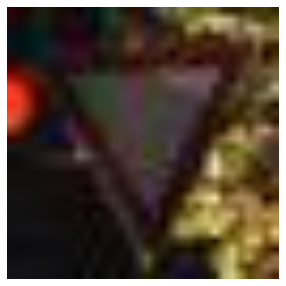

In [24]:
prediction('../input/traffic-signs-classification/myData/13/00000_00023.jpg')

##### Esempio 2


Segnale stradale riconosciuto: Speed limit (50km/h) 



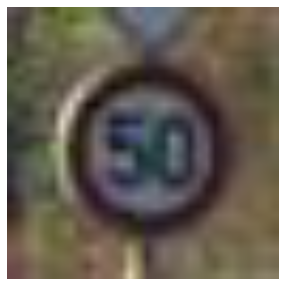

In [25]:
prediction('../input/traffic-signs-classification/myData/2/00000_00017.jpg')

##### Esempio 3


Segnale stradale riconosciuto: Bicycles crossing 



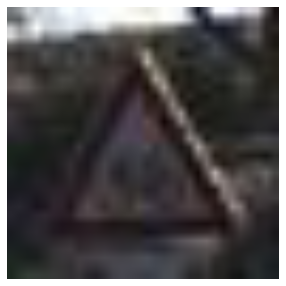

In [26]:
prediction('../input/traffic-signs-classification/myData/29/00000_00019.jpg')

##### Esempio 4


Segnale stradale riconosciuto: Speed limit (100km/h) 



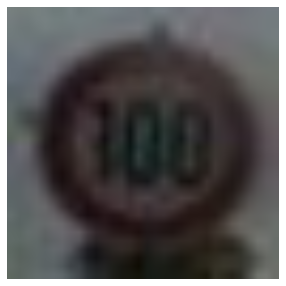

In [27]:
prediction('../input/traffic-signs-classification/myData/7/00000_00025.jpg')

##### Esempio 5


Segnale stradale riconosciuto: Stop 



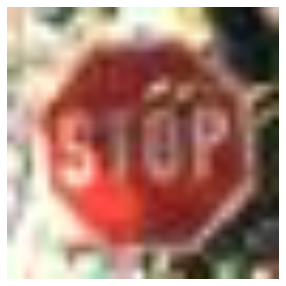

In [28]:
prediction('../input/traffic-signs-classification/myData/14/00000_00019.jpg')

#### Salvataggio del modello utile per il processo di quantizzazione

In [29]:
# invia il modello verso la cpu
model = model.to(torch.device('cpu'),non_blocking=True)

torch.save(model.state_dict(),'traffic_sign_recognition_LeNet.pth')

### Pulizia memoria della GPU


In [30]:
torch.cuda.empty_cache()

### Conclusioni 

Attraverso l'intero progetto, abbiamo costruito e addestrato un modello di rete neurale convoluzionale in grado di riconoscere i segnali stradali elaborando le immagini che li contengono.

L'architettura di questo modello è la seguente:

3 strati di convoluzione con rispettivamente 16, 32 e 64 canali di output, insieme a normalizzazione batch, attivazione Relu e max pooling.
Successivamente, è presente uno strato di appiattimento per trasformare l'output dell'ultimo strato in una rappresentazione bidimensionale, seguito da due strati lineari con una funzione di attivazione Relu nel mezzo, con dimensioni di output pari a 256 e 43 rispettivamente.
L'intero notebook, dal principio alla fine, segue una pipeline che include l'importazione delle librerie, il caricamento del dataset, il bilanciamento del dataset, la suddivisione del dataset per addestramento e test, la visualizzazione di 100 immagini di addestramento in formato griglia, la creazione del modello, la valutazione del modello prima dell'addestramento (per confrontare le prestazioni iniziali), la creazione di una funzione per l'addestramento del modello, l'addestramento del modello con 25 epoche e 200 passi per epoca (che richiede solo 1 minuto con un'accuratezza di test circa del 97,8%).

Durante l'addestramento di questo modello, abbiamo utilizzato anche la tecnica di scheduling del tasso di apprendimento con politica a ciclo singolo per aggiornare il tasso di apprendimento e il clipping del gradiente per limitare i valori del gradiente.

Dopo l'addestramento del modello, abbiamo visualizzato la cronologia dell'addestramento, mostrato il report di classificazione e infine creato una funzione di previsione e fatto previsioni su alcune immagini scelte casualmente.